## Practice Project

### Imports and Data Retrieval

To start out, we're importing some packages that will allow us to retrieve our data and set up our DataFrame so it is prepared for our backtest. 

In [1]:
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
import tpqoa
api = tpqoa.tpqoa('oanda.cfg')

We will be testing the week of April 7, 2024 to April 12, 2024. Using EUR_USD because BCO_USD is not tradable for me. 

In [2]:
instrument = 'EUR_USD'
start = '2024-04-07'
end = '2024-04-14'
granularity = 'M5'
price = 'M'

In [3]:
raw = api.get_history(instrument, start, end,
                       granularity, price)

In [4]:
data = raw[['c']] #using closing price data

In [5]:
data = data.rename(columns={'c' : 'price'}) #renaming 'c' to 'price' for convenience

In [6]:
data['return'] = np.log(data['price'] / data['price'].shift(1)) #calculating log returns

We want our model to use the price data, the returns data, and lags of the returns data to make its prediction on the future returns of the underlying.

In [7]:
lags = 3 #adding lags
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

### Testing The Model

In [8]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

We chose to use the AdaBoostRegressor in conjunction with the DecisionTreeRegressor.

In [9]:
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), 
                          n_estimators=300, random_state=42)

In [10]:
data.head(1)

,price,return,lag_1,lag_2,lag_3
time,,,,,
2024-04-07 21:20:00,1.0838,-0.000018,-0.000037,0.000129,-0.000101


Training the model to use columns that include price, return, and the lags in order to predict the direction. 

In [11]:
ensemble = model.fit(data[cols], data['return'])

Generating prediction based on our features. We then create a new column that documents the prediction in a binary fashion, which we will use later on to initiate positions.

In [12]:
prediction = ensemble.predict(data[cols])
data['prediction'] = np.where(prediction > 0, 1, -1)

Adding a 'strategy' column that will take the prediction, and multiply it by the returns. This will help us evaluate the viability of the model.

In [13]:
data['strategy'] = (data['prediction'] *
                    data['return'])

Plotting the result of the backtest. It looks great right now, but we aren't expecting it to perform this well when confronted with market realities (slippage, commissions, etc).

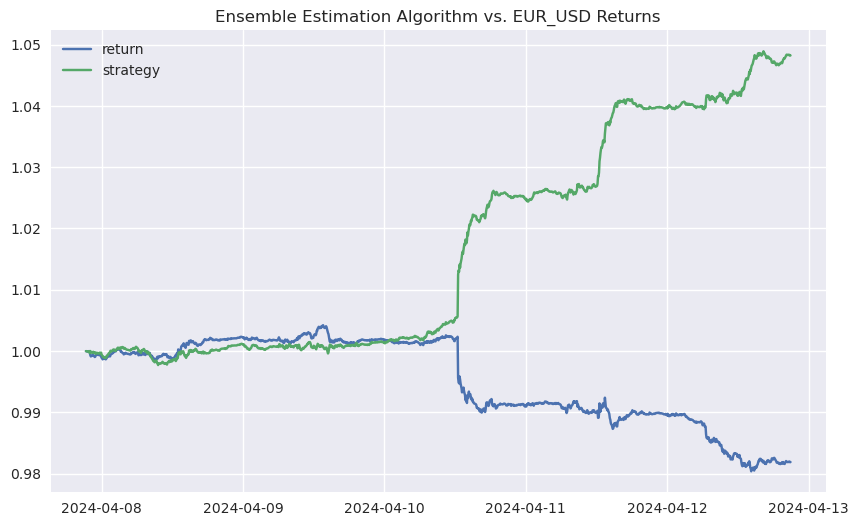

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(data['return'].cumsum().apply(np.exp), label='return')
plt.plot(data['strategy'].cumsum().apply(np.exp), label='strategy')
plt.title(f'Ensemble Estimation Algorithm vs. {instrument} Returns')
plt.legend();

### Real-Time Implementation

- api.create_order(instrument, 1000)
- api.stream_data
- api.on_success
- api.get_account_summary
- api.get_transtactions


In [15]:
import warnings
warnings.simplefilter('ignore')

In [16]:
import EnsembleTrader as ES

Instantiation. For the model to work: you need a config file, choose your instrument (already chosen earlier in the notebook), the fitted model, how many units you want to trade, how long you want to stream the data for, and the lags (since the model is fitted on 3, we used 3 here).

In [17]:
es = ES.EnsembleTrader('oanda.cfg',
                    instrument = instrument,
                    bar_length = '5T',
                    ensemble = ensemble,
                    units = 50000,
                    stop  = None,
                    lags = 3)

This runs the model on live data. It also automatically flattens open positions when you keyboard interrupt the streaming. 

In [18]:
es.begin_trading(instrument, stop=None)

Trading algorithm is running as of 2024-04-18 18:38:54.913001


 {'id': '539', 'time': '2024-04-18T19:00:05.917012230Z', 'userID': 26551786, 'accountID': '101-001-26551786-001', 'batchID': '538', 'requestID': '97258793224770179', 'type': 'ORDER_FILL', 'orderID': '538', 'instrument': 'EUR_USD', 'units': '50000.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.06459, 'fullVWAP': 1.06459, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.06443, 'liquidity': '10000000'}], 'asks': [{'price': 1.06459, 'liquidity': '10000000'}], 'closeoutBid': 1.06443, 'closeoutAsk': 1.06459}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99343.024', 'tradeOpened': {'tradeID': '539', 'units': '50000.0', 'price': 1.06459, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '4.0', 'initialMarginRequired': '1064.51'}, 'halfSpreadCost': '4.0'} 



 {'id': '541', 'time': '2024-04-18T1

### Reviewing The Performance

In [19]:
import pandas as pd

First, we take the transactions from the API. We then create a DataFrame with the relevant data to evaluate performance. Then, we calculate the returns. We needed to dropna before calculating the returns because when the model has an open position of, say, 50000, then sells 100000 to go short, it counts the flatten order as an order with NaN values that are not necessary for our evaluation. 

In [20]:
trades = api.get_transactions(tid='518')
transactions = pd.DataFrame(trades)
transactions = transactions[['id', 'time', 'pl']]
transactions['time'] = pd.to_datetime(transactions['time'])
transactions = transactions.set_index('time')
transactions['pl'] = transactions['pl'].astype(float)
transactions['cumpl'] = transactions['pl'].cumsum()
transactions['balance'] = 50000 + transactions['cumpl']
transactions.dropna(inplace=True)
transactions['returns'] = np.log(transactions['balance'] / transactions['balance'].shift(1))

We then plot the trades' P&L, the account balance (50,000 starting balance), and the strategy's % returns. 

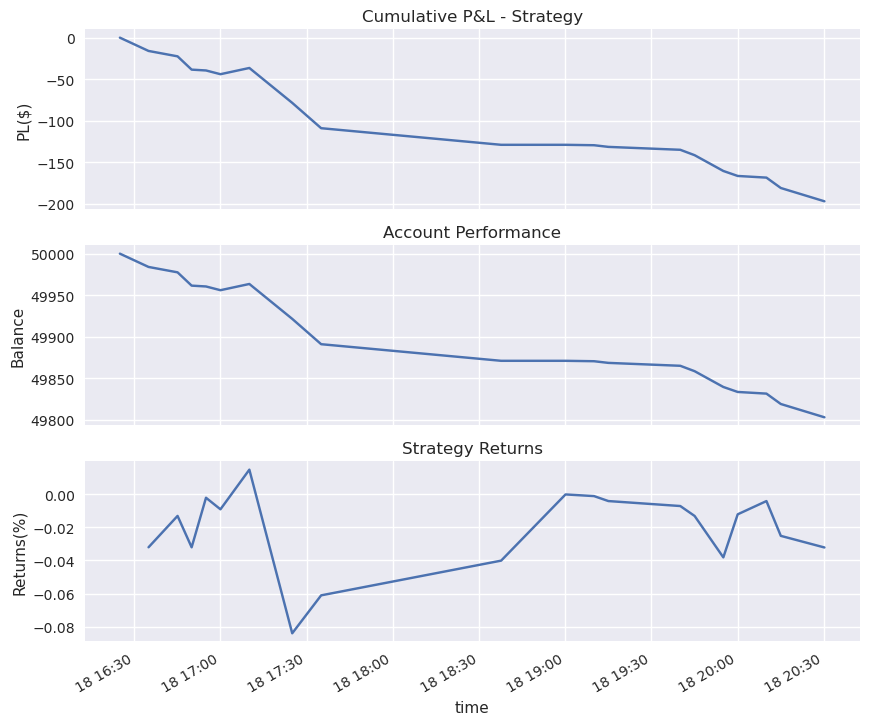

In [21]:
fig, ax1 = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
plt.subplot(311)
transactions['cumpl'].plot()
plt.title('Cumulative P&L - Strategy')
plt.ylabel('PL($)')
plt.subplot(312)
transactions['balance'].plot()
plt.title('Account Performance')
plt.ylabel('Balance')
plt.subplot(313)
(transactions['returns'] * 100).plot()
plt.title('Strategy Returns')
plt.ylabel('Returns(%)');